<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 235, '日付': '2021-06-07T08:00:00.000Z'},
 {'小計': 369, '日付': '2021-06-08T08:00:00.000Z'},
 {'小計': 440, '日付': '2021-06-09T08:00:00.000Z'},
 {'小計': 439, '日付': '2021-06-10T08:00:00.000Z'},
 {'小計': 435, '日付': '2021-06-11T08:00:00.000Z'},
 {'小計': 467, '日付': '2021-06-12T08:00:00.000Z'},
 {'小計': 304, '日付': '2021-06-13T08:00:00.000Z'},
 {'小計': 209, '日付': '2021-06-14T08:00:00.000Z'},
 {'小計': 337, '日付': '2021-06-15T08:00:00.000Z'},
 {'小計': 501, '日付': '2021-06-16T08:00:00.000Z'},
 {'小計': 452, '日付': '2021-06-17T08:00:00.000Z'},
 {'小計': 453, '日付': '2021-06-18T08:00:00.000Z'},
 {'小計': 388, '日付': '2021-06-19T08:00:00.000Z'},
 {'小計': 376, '日付': '2021-06-20T08:00:00.000Z'},
 {'小計': 236, '日付': '2021-06-21T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-06-17 17:00:00+09:00,356,0,452,2021-06-17 17:00:00+09:00
2021-06-18 17:00:00+09:00,314,0,453,2021-06-18 17:00:00+09:00
2021-06-19 17:00:00+09:00,347,0,388,2021-06-19 17:00:00+09:00
2021-06-20 17:00:00+09:00,334,0,376,2021-06-20 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-06-17 17:00:00+09:00,356,0,452,2021-06-17 17:00:00+09:00,330.285714,2312.0,0.0,0.0,386.428571,2705.0
2021-06-18 17:00:00+09:00,314,0,453,2021-06-18 17:00:00+09:00,330.428571,2313.0,0.0,0.0,389.000000,2723.0
2021-06-19 17:00:00+09:00,347,0,388,2021-06-19 17:00:00+09:00,330.000000,2310.0,0.0,0.0,377.714286,2644.0
2021-06-20 17:00:00+09:00,334,0,376,2021-06-20 17:00:00+09:00,337.285714,2361.0,0.0,0.0,388.000000,2716.0
2021-06-21 17:00:00+09:00,0,0,236,2021-06-21 17:00:00+09:00,286.714286,2007.0,0.0,0.0,391.857143,2743.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-06-07 17:00:00+09:00,391,0,235,2021-06-07 17:00:00+09:00,367.428571,2572.0,0.0,0.0,422.857143,2960.0,'21w23,Mon
2021-06-08 17:00:00+09:00,293,0,369,2021-06-08 17:00:00+09:00,352.142857,2465.0,0.0,0.0,408.285714,2858.0,'21w23,Tue
2021-06-09 17:00:00+09:00,336,0,440,2021-06-09 17:00:00+09:00,344.714286,2413.0,0.0,0.0,401.571429,2811.0,'21w23,Wed
2021-06-10 17:00:00+09:00,322,0,439,2021-06-10 17:00:00+09:00,337.714286,2364.0,0.0,0.0,391.714286,2742.0,'21w23,Thu
2021-06-11 17:00:00+09:00,313,0,435,2021-06-11 17:00:00+09:00,333.857143,2337.0,0.0,0.0,386.428571,2705.0,'21w23,Fri
2021-06-12 17:00:00+09:00,350,0,467,2021-06-12 17:00:00+09:00,332.000000,2324.0,0.0,0.0,390.857143,2736.0,'21w23,Sat
2021-06-13 17:00:00+09:00,283,0,304,2021-06-13 17:00:00+09:00,326.857143,2288.0,0.0,0.0,384.142857,2689.0,'21w23,Sun
2021-06-14 17:00:00+09:00,354,0,209,2021-06-14 17:00:00+09:00,321.571429,2251.0,0.0,0.0,380.428571,2663.0,'21w24,Mon
2021-06-15 17:00:00+09:00,337,0,337,2021-06-15 17:00:00+09:00,327.857143,2295.0,0.0,0.0,375.857143,2631.0,'21w24,Tue
2021-06-16 17:00:00+09:00,319,0,501,2021-06-16 17:00:00+09:00,325.428571,2278.0,0.0,0.0,384.571429,2692.0,'21w24,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-06-06 17:00:00+09:00,426.428571,2985
2021-06-13 17:00:00+09:00,384.142857,2689
2021-06-20 17:00:00+09:00,388.000000,2716
2021-06-21 17:00:00+09:00,236.000000,236
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-06-07 17:00:00+09:00,391,0,235,2021-06-07 17:00:00+09:00,367.428571,2572.0,0.0,0.0,422.857143,2960.0,'21w23,Mon,NaN,NaN
2021-06-08 17:00:00+09:00,293,0,369,2021-06-08 17:00:00+09:00,352.142857,2465.0,0.0,0.0,408.285714,2858.0,'21w23,Tue,NaN,NaN
2021-06-09 17:00:00+09:00,336,0,440,2021-06-09 17:00:00+09:00,344.714286,2413.0,0.0,0.0,401.571429,2811.0,'21w23,Wed,NaN,NaN
2021-06-10 17:00:00+09:00,322,0,439,2021-06-10 17:00:00+09:00,337.714286,2364.0,0.0,0.0,391.714286,2742.0,'21w23,Thu,NaN,NaN
2021-06-11 17:00:00+09:00,313,0,435,2021-06-11 17:00:00+09:00,333.857143,2337.0,0.0,0.0,386.428571,2705.0,'21w23,Fri,NaN,NaN
2021-06-12 17:00:00+09:00,350,0,467,2021-06-12 17:00:00+09:00,332.000000,2324.0,0.0,0.0,390.857143,2736.0,'21w23,Sat,NaN,NaN
2021-06-13 17:00:00+09:00,283,0,304,2021-06-13 17:00:00+09:00,326.857143,2288.0,0.0,0.0,384.142857,2689.0,'21w23,Sun,384.142857,2689.0
2021-06-14 17:00:00+09:00,354,0,209,2021-06-14 17:00:00+09:00,321.571429,2251.0,0.0,0.0,380.428571,2663.0,'21w24,Mon,NaN,NaN
2021-06-15 17:00:00+09:00,337,0,337,2021-06-15 17:00:00+09:00,327.857143,2295.0,0.0,0.0,375.857143,2631.0,'21w24,Tue,NaN,NaN
2021-06-16 17:00:00+09:00,319,0,501,2021-06-16 17:00:00+09:00,325.428571,2278.0,0.0,0.0,384.571429,2692.0,'21w24,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

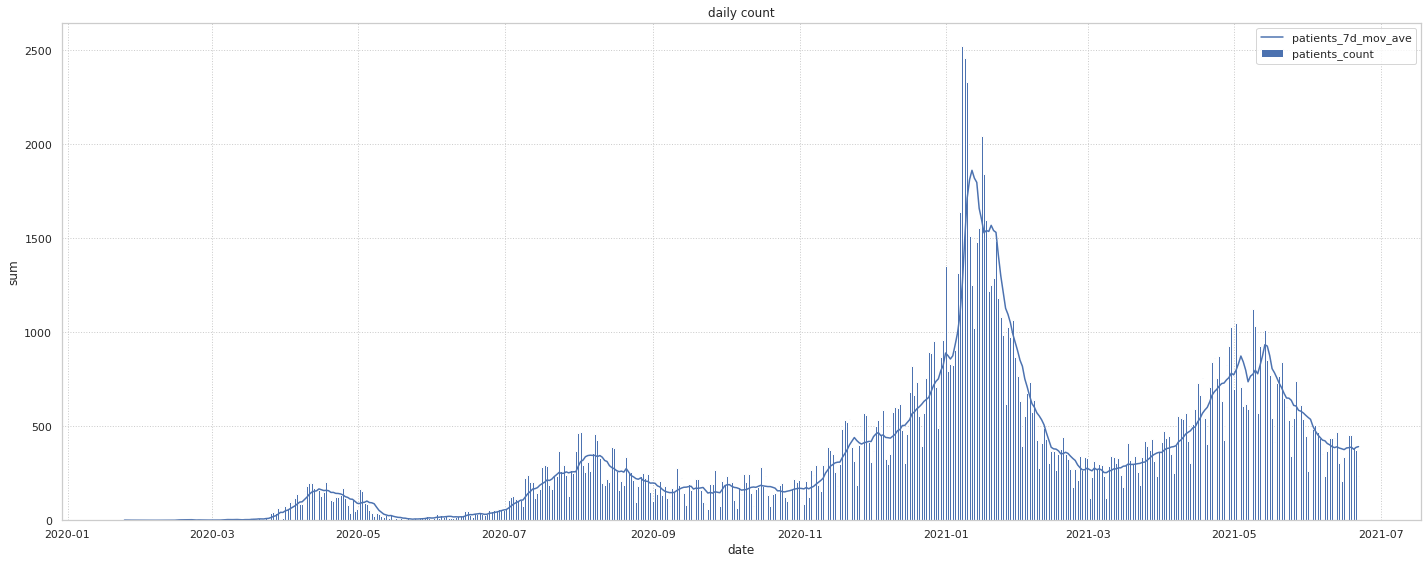

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
500,1.623053e+09,2021,6,7,0,1,0,0,0,0,0,500,0,426,391,367.428571,2572.0,0,0.0,0.0,235,422.857143,2960.0
501,1.623139e+09,2021,6,8,0,0,0,0,0,1,0,501,0,427,293,352.142857,2465.0,0,0.0,0.0,369,408.285714,2858.0
502,1.623226e+09,2021,6,9,0,0,0,0,0,0,1,502,0,428,336,344.714286,2413.0,0,0.0,0.0,440,401.571429,2811.0
503,1.623312e+09,2021,6,10,0,0,0,0,1,0,0,503,0,429,322,337.714286,2364.0,0,0.0,0.0,439,391.714286,2742.0
504,1.623398e+09,2021,6,11,1,0,0,0,0,0,0,504,0,430,313,333.857143,2337.0,0,0.0,0.0,435,386.428571,2705.0
505,1.623485e+09,2021,6,12,0,0,1,0,0,0,0,505,0,431,350,332.000000,2324.0,0,0.0,0.0,467,390.857143,2736.0
506,1.623571e+09,2021,6,13,0,0,0,1,0,0,0,506,0,432,283,326.857143,2288.0,0,0.0,0.0,304,384.142857,2689.0
507,1.623658e+09,2021,6,14,0,1,0,0,0,0,0,507,0,433,354,321.571429,2251.0,0,0.0,0.0,209,380.428571,2663.0
508,1.623744e+09,2021,6,15,0,0,0,0,0,1,0,508,0,434,337,327.857143,2295.0,0,0.0,0.0,337,375.857143,2631.0
509,1.623830e+09,2021,6,16,0,0,0,0,0,0,1,509,0,435,319,325.428571,2278.0,0,0.0,0.0,501,384.571429,2692.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            515 non-null    float64
 1   year                 515 non-null    int64  
 2   month                515 non-null    int64  
 3   day                  515 non-null    int64  
 4   Fri                  515 non-null    uint8  
 5   Mon                  515 non-null    uint8  
 6   Sat                  515 non-null    uint8  
 7   Sun                  515 non-null    uint8  
 8   Thu                  515 non-null    uint8  
 9   Tue                  515 non-null    uint8  
 10  Wed                  515 non-null    uint8  
 11  passed               515 non-null    int64  
 12  emergency            515 non-null    int64  
 13  em_passed            515 non-null    int64  
 14  contacts_count       515 non-null    int64  
 15  contacts_7d_mov_ave  515 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.150000e+02,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,1.602058e+09,2020.333981,5.712621,15.691262,0.143689,0.143689,0.143689,0.143689,0.141748,0.141748,0.141748,257.000000,0.095146,188.388350,658.704854,657.310356,4601.165049,715.570874,715.570874,5008.996117,328.778641,326.671650,2286.669903
std,1.285735e+07,0.472091,3.268607,8.809474,0.351115,0.351115,0.351115,0.351115,0.349130,0.349130,0.349130,148.811962,0.293701,140.967352,433.940472,421.389676,2949.739302,866.455187,778.893918,5452.257427,366.653105,346.574000,2426.047837
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.590955e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,128.500000,0.000000,54.500000,373.500000,377.785714,2644.500000,0.000000,0.000000,0.000000,67.000000,81.285714,569.000000
50%,1.602058e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,257.000000,0.000000,183.000000,525.000000,539.714286,3778.000000,237.000000,572.857143,4010.000000,226.000000,225.428571,1578.000000
75%,1.613160e+09,2021.000000,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,385.500000,0.000000,311.500000,770.000000,752.000000,5264.000000,1340.000000,1344.571429,9412.000000,447.000000,440.214286,3081.500000
max,1.624262e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,514.000000,1.000000,440.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.816894,0.081180,-0.012620,-0.004133,0.004133,-0.001378,0.001378,0.002734,-0.002734,4.036436e-19,1.000000e+00,-0.346806,0.995769,-0.311001,-0.294476,-0.294471,-0.543842,-0.586423,-0.586423,0.608820,0.652586,0.652601
year,8.168936e-01,1.000000,-0.506303,-0.050942,0.003350,0.003350,0.003350,0.003350,-0.004492,-0.004492,-4.492336e-03,8.168936e-01,-0.229627,0.835258,-0.295393,-0.273473,-0.273470,-0.585391,-0.651199,-0.651199,0.589625,0.649550,0.649551
month,8.117958e-02,-0.506303,1.000000,-0.019033,-0.013111,0.000451,-0.008025,-0.004635,0.011898,0.005078,8.487848e-03,8.117958e-02,-0.119404,0.042872,0.048877,0.035330,0.035333,0.200911,0.252527,0.252527,-0.111748,-0.151354,-0.151334
day,-1.262038e-02,-0.050942,-0.019033,1.000000,0.012483,-0.000096,0.001161,0.009967,-0.000292,-0.015474,-7.883009e-03,-1.262038e-02,0.000096,-0.011752,-0.011897,-0.009320,-0.009324,0.013323,-0.000514,-0.000514,-0.009125,0.002595,0.002581
Fri,-4.133063e-03,0.003350,-0.013111,0.012483,1.000000,-0.167800,-0.167800,-0.167800,-0.166474,-0.166474,-1.664742e-01,-4.133063e-03,-0.000769,-0.003174,-0.017508,-0.003634,-0.003633,0.032933,-0.002182,-0.002182,0.047489,-0.002030,-0.002039
Mon,4.133063e-03,0.003350,0.000451,-0.000096,-0.167800,1.000000,-0.167800,-0.167800,-0.166474,-0.166474,-1.664742e-01,4.133063e-03,-0.000769,0.004255,0.034449,-0.002355,-0.002354,0.136007,-0.002182,-0.002182,-0.133874,0.000243,0.000245
Sat,-1.377688e-03,0.003350,-0.008025,0.001161,-0.167800,-0.167800,1.000000,-0.167800,-0.166474,-0.166474,-1.664742e-01,-1.377688e-03,-0.000769,-0.000697,0.045162,-0.002983,-0.002982,-0.161220,-0.002182,-0.002182,0.061165,-0.001146,-0.001152
Sun,1.377688e-03,0.003350,-0.004635,0.009967,-0.167800,-0.167800,-0.167800,1.000000,-0.166474,-0.166474,-1.664742e-01,1.377688e-03,-0.000769,0.001779,-0.024148,-0.002355,-0.002354,-0.148692,-0.002182,-0.002182,-0.038092,-0.000293,-0.000294
Thu,2.733597e-03,-0.004492,0.011898,-0.000292,-0.166474,-0.166474,-0.166474,-0.166474,1.000000,-0.165158,-1.651584e-01,2.733597e-03,0.001032,0.001765,-0.004295,0.004444,0.004445,0.043112,0.002925,0.002925,0.081800,0.002156,0.002162
Tue,-2.733597e-03,-0.004492,0.005078,-0.015474,-0.166474,-0.166474,-0.166474,-0.166474,-0.165158,1.000000,-1.651584e-01,-2.733597e-03,0.001032,-0.003216,-0.022016,0.003169,0.003170,0.057987,0.002925,0.002925,-0.034406,-0.000031,-0.000027


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,1.623917e+09,0,0,0,0,1,0,0,510,0,436,356,0,452,386.428571,2705.0
511,1.624003e+09,1,0,0,0,0,0,0,511,0,437,314,0,453,389.000000,2723.0
512,1.624090e+09,0,0,1,0,0,0,0,512,0,438,347,0,388,377.714286,2644.0
513,1.624176e+09,0,0,0,1,0,0,0,513,0,439,334,0,376,388.000000,2716.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
510,1.623917e+09,510,0,452,386.428571,2705.0
511,1.624003e+09,511,0,453,389.000000,2723.0
512,1.624090e+09,512,0,388,377.714286,2644.0
513,1.624176e+09,513,0,376,388.000000,2716.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

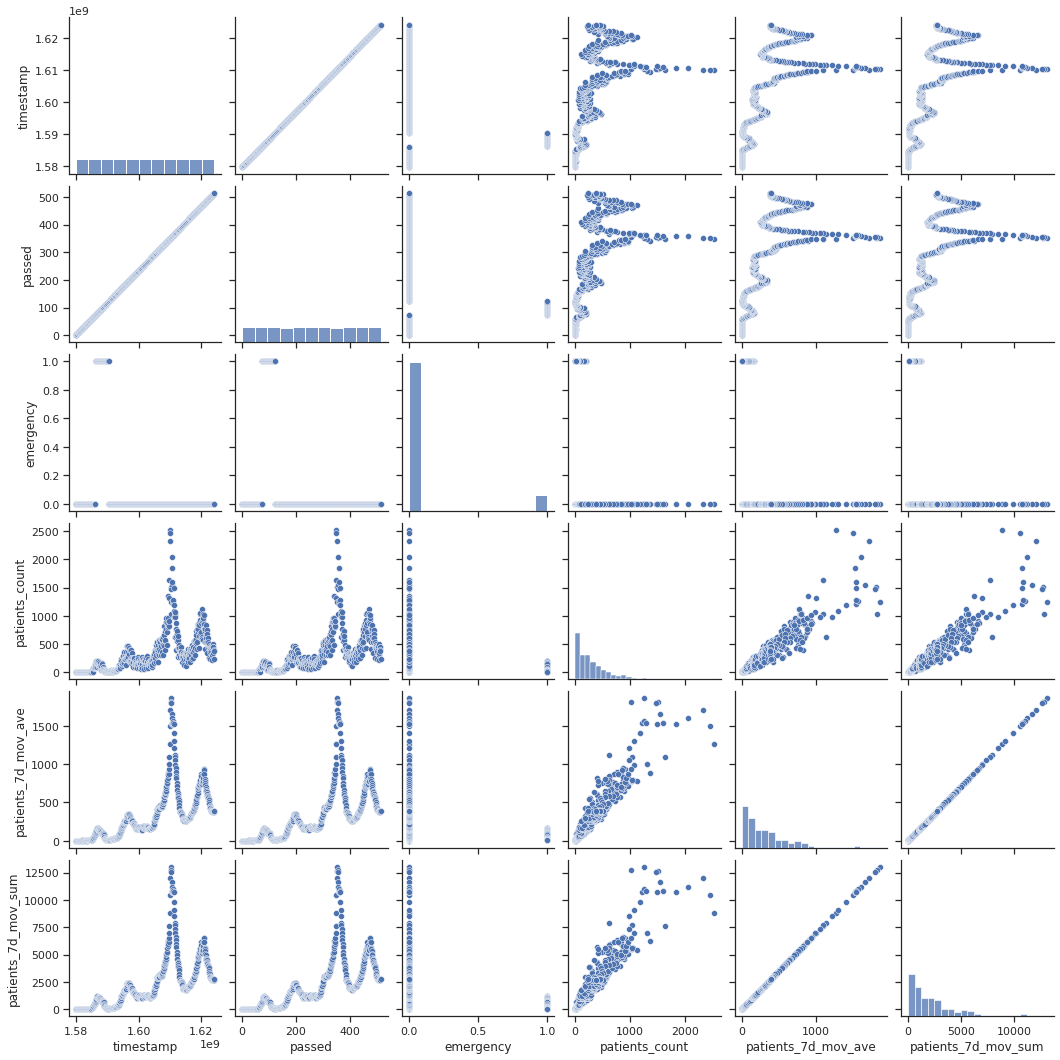

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
